In [2]:
%matplotlib inline
import numpy as np

import matplotlib.animation as anim
import matplotlib.pyplot as plt
from vlasov import Efield,Species,Plasma

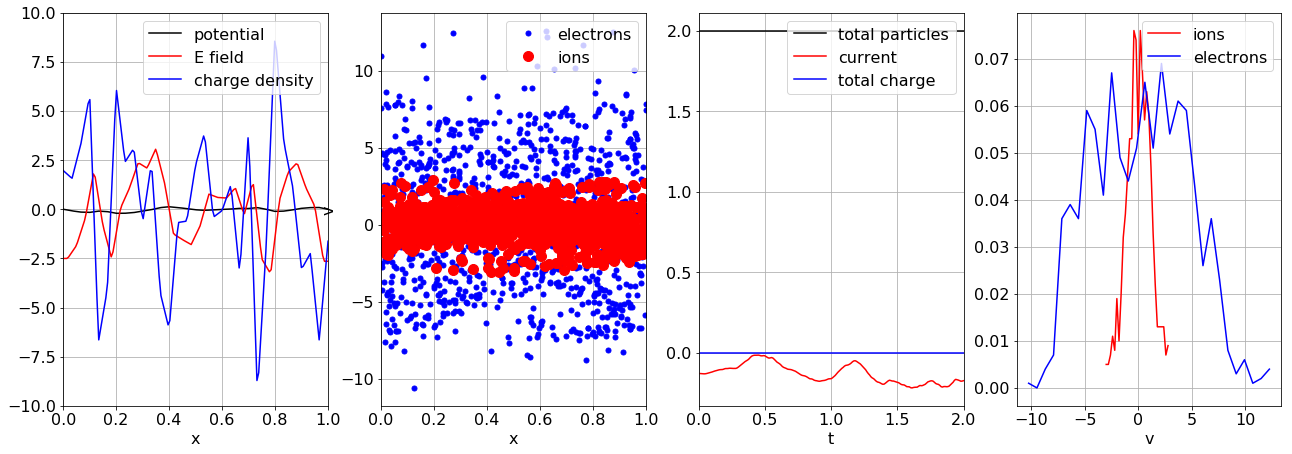

In [12]:
dt=1.e-2
tfin=2.

e=Efield(nintervals=30,voltage=0.,frequency=0.2)
ion=Species(nparticles=1000,mass=1.,charge=1.,temperature=1.)
ele=Species(nparticles=1000,mass=1/10.,charge=-1.,temperature=1.)
plas=Plasma(ions=ion,electrons=ele,electric_field=e)

# cosmetics
plt.rcParams.update({'font.size': 16})
fig,alist = plt.subplots(1,4,figsize=(18,6))
fig.subplots_adjust(left=0.05, bottom=0.08, right=0.99, top=0.99, wspace=None, hspace=None)

# plasma box
alist[0].set_xlim(0., 1.)
alist[0].set_ylim(-10.,10.)
alist[0].set_xlabel('x')

#particle phase-space
alist[1].set_xlim(0.,1.)
alist[1].set_xlabel('x')
alist[1].set_ylabel('v')

# time recording
alist[2].set_xlim(0,tfin)
alist[2].set_xlabel('t')

# histograms
alist[3].set_xlabel('v')

# definition of plots
pot, = alist[0].plot([],[],'-k',label='potential')
efi, = alist[0].plot([],[],'-r',label='E field')
cha, = alist[0].plot([],[],'-b',label='charge density')
pe,  = alist[1].plot([],[],'.b',markersize=10,label='electrons')
pi,  = alist[1].plot([],[],'.r',markersize=20,label='ions')
npa, = alist[2].plot([],[],'-k',label='total particles')
cur, = alist[2].plot([],[],'-r',label='current')
qto, = alist[2].plot([],[],'-b',label='total charge')
hii, = alist[3].plot([],[],'-r',label='ions')
hie, = alist[3].plot([],[],'-b',label='electrons')

plist=(pe,pi,pot,efi,cha,npa,cur,qto,hii,hie)  # for convenience

# default settings
for a in alist:
    a.grid()
    a.set_autoscale_on
    a.legend(loc='upper right')

def init():
    for e in plist:
        e.set_data([],[])
        
    return plist

def animate(i):
    global dt, fig, alist, plas
    
    plas.evolve(dt)
    
    # electric field plotting
    x=np.linspace(0.,1.,150)
    pot.set_data(x,e.eval_potential(x))
    cha.set_data(x,e.eval_charge_density(x))
    efi.set_data(x,e.eval_field(x))
    
    # particle phase-space plotting
    pi.set_data(ion.pos(),ion.vel())
    pe.set_data(ele.pos(),ele.vel())
    
    # time traces plotting
    npa.set_xdata(np.append(npa.get_xdata(),e.t))
    npa.set_ydata(np.append(npa.get_ydata(),plas.particle_number()))
                  
    cur.set_xdata(np.append(cur.get_xdata(),e.t))
    cur.set_ydata(np.append(cur.get_ydata(),plas.current()))
    
    qto.set_xdata(np.append(qto.get_xdata(),e.t))
    qto.set_ydata(np.append(qto.get_ydata(),plas.global_charge()))
    
    # histograms in velocity space
    [n,b]=np.histogram(ion.vel(),bins=30,weights=ion.w)
    bc=b[:-1]+0.5*np.diff(b)
    hii.set_data(bc,n)
    
    [n,b]=np.histogram(ele.vel(),bins=30,weights=ele.w)
    bc=b[:-1]+0.5*np.diff(b)
    hie.set_data(bc,n)
    
    # axis cosmetics
    for a in alist:
        a.relim()
        a.autoscale_view()
        
    return plist

ani = anim.FuncAnimation(fig,animate,frames=int(tfin/dt),interval=10,blit=True,init_func=init)

ani.save('vlasov_solver.mp4',fps=24,extra_args=['-vcodec','libx264'])
    
plt.show()

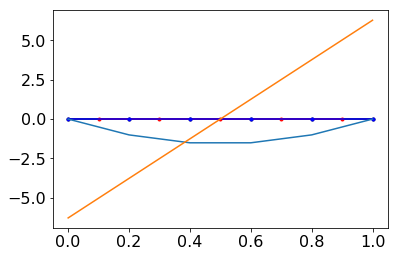

In [19]:
e=Efield(nintervals=5,voltage=0.)
e.charge_density.fill(0.)
e.solve()
plt.plot(e.grid,e.potential,'.-k')
plt.plot(e.half_grid,e.efield,'.-r')
plt.plot(e.grid,e.charge_density,'.-b')
plt.plot(e.grid,4*np.pi*1./2.*e.grid*(e.grid-1.))
plt.plot(e.grid,4*np.pi*(e.grid-0.5))


In [20]:
ion=Species(2)
e.deposit(ion)

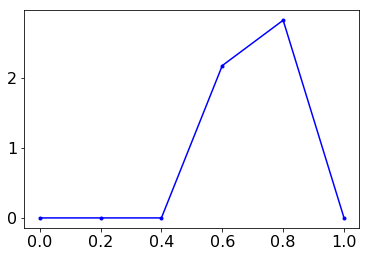

In [21]:

plt.plot(e.grid,e.charge_density,'.-b')